# PaMoDaCo: CMIP6 vs LMR

---

## Overview
<font color=green> This notebook compares the output of physics-based models of the climate of the past millennium to reconstructions from the Last Millennium Reanalysis project and allows a quick glance at the simulated and reconstructed climate response to major volcanic events of the Common Era. In the process, it illustrates how to: </font>

1. Pull and process CMIP6 output from AWS
1. Plot an envelope of LMR simulations with CMIP6 output
1. Plot spatial variation of LMR and CMIP6 snapshots

- **Time to learn**: 25 minutes

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [Accessing CMIP6 output from the cloud](data_from_esm_cloudcat.ipynb) | Helpful | Background about the structure of the data catalog |



---

## Imports

In [56]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np

import xarray as xr
import cftime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec

import pyleoclim as pyleo

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import intake

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data-model comparison of global-mean surface temperature

### Last Millennium Reanalysis Project (LMR) 

Many methods have been proposed to reconstruct past climates. An increasingly mature and popular framework is that of [paleoclimate data assimilation](https://pastglobalchanges.org/publications/pages-magazines/pages-magazine/7318), which has been applied to many time intervals. In particular, the [Last Millennium Reanalysis](https://cpo.noaa.gov/News/News-Article/ArtMID/6226/ArticleID/1807/Last-Millennium-Reanalysis-now-at-NOAAs-National-Centers-for-Environmental-Information-marking-major-milestone) provides estimates of gridded climate fields like surface air temperature, sea-level pressure, precipitation, and others, together with estimates of their uncertainties (which are often at least as important as the central estimates). (Hakim et al, 2016 and Tardif et al, 2019)

In a nutshell, LMR blends information from paleoclimate proxies and climate models, with models providing estimates of relationships over space and between variables, while proxies give the timing and amplitude of events. To explore the full distribution of possible trajectories, LMR uses an [ensemble Kalman filter](https://en.wikipedia.org/wiki/Ensemble_Kalman_filter), which employs a Monte Carlo approach to this exploration: each reconstruction starts with a sample of 100 randomly-drawn climate snapshots from a model simulation (each such snapshot is called a _member_). Proxy measurements for each year are used to establish the likelihood of each climate snapshot. In addition, the algorithm conducts 20-50 "iterations", where it selects 75% of the catalog of proxies and reserves the other 25% for validation.
By doing this many times (50 iterations each with different 100 snapshots) we can build a 5000-strong picture of how the climate of the Common Era may have unfolded, capturing uncertainties about this history.


We'll load datasets using **[Xarray](https://xarray.dev/)**. Xarray is specifically designed to accommodate multidimensional data, like that from a NetCDF file. Let's load 1000 traces of GMST reconstructed using LMR included in Neukom et al. (2019).  

In [57]:
file_path = Path(os.getcwd()).parent.parent/'data/p2k_ngeo19_recons.nc'
p2k_nc = xr.open_dataset(file_path)
p2k_nc

<xarray.Dataset>
Dimensions:  (year: 2000, ens: 1000)
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 ... 1994 1995 1996 1997 1998 1999 2000
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000
Data variables:
    LMRv2.1  (year, ens) float32 ...
    BHM      (year, ens) float64 ...
    DA       (year, ens) float64 ...
    CPS_new  (year, ens) float64 ...
    CPS      (year, ens) float64 ...
    OIE      (year, ens) float64 ...
    PAI      (year, ens) float64 ...
    PCR      (year, ens) float64 ...
    M08      (year, ens) float64 ...

In [58]:
%%time
variable_name = 'LMRv2.1'
ens_grps = p2k_nc.groupby('ens')
traces = []

for im in range(len(p2k_nc.ens)):
    ens_run = ens_grps[im+1].data_vars[variable_name]
    traces.append(pyleo.Series(time=p2k_nc.year, value=ens_run,
                      time_name='Time', time_unit='year',
                      value_name='GMST', value_unit='$^{\circ}$C', verbose=False))

lmr_ens = pyleo.EnsembleSeries(traces);

CPU times: user 2.45 s, sys: 657 ms, total: 3.11 s
Wall time: 4.36 s


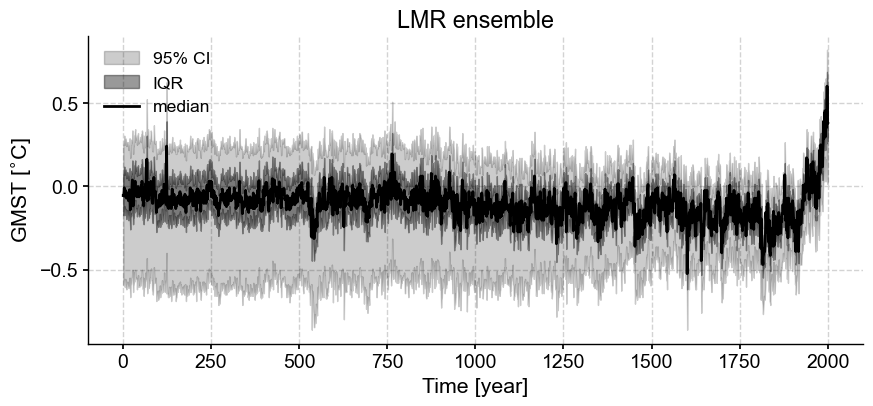

In [59]:
lmr_ens.plot_envelope(title='LMR ensemble', shade_clr='k', curve_clr='k'); 

### CMIP6 & PMIP4

The Climate Model Intercomparison Project Phase 6 (CMIP6) is a major international effort to organize climate simulations by specifying a standardized menu of experiments, providing data-sharing infrastructure (which guides output toward a homogeneous structure and nomenclature), and requiring each participating model to submit the following entry card simulations as a baseline:
- Pre-industrial control (piControl)
- Abrupt-4xCO2
- 1% per year increase in CO2 (1pctCO2)
- Atmospheric Model Intercomparison Project (AMIP)
- Simulations of the period 1850-2014 (historical)

The Paleoclimate Modeling Intercomparison Project (PMIP) component of CMIP6 focused on simulating climate thousands (or more) years ago. The PMIP community develops forcing files for each experiment based on proxy and other climate data so that each model starts from a common set of initial conditions for factors such as greenhouse gas concentrations, solar radiation, land cover, and ice sheet extent. While submitting PMIP simulations is not a requirement for participating in CMIP6, simulating climate beginning with conditions notably different from those specified for the historical benchmark provides important information about the robustness of a model's physics. All PMIP participants were required to submit output for three entry-card experiments plus any of the optional experiments.  As of spring 2023, output is still coming in from the [19 institutions signed up to participate in PMIP4](https://pmip4.lsce.ipsl.fr/doku.php/database:participants), but so far, data is available via the Earth System Grid Federation for:
- [entry-card] Mid-Holocene (MH): 16
- [entry-card] Last Glacial Maximum (LGM): 6
- [entry-card] Last Interglacial (LIG): 15
- Last Millennium (past1000): 4
- Past2k (past2k): 1

#### Cloud-ready data
Data is readily available for download via the [ESGF website](https://esgf-node.ipsl.upmc.fr/search/cmip6-ipsl/), and additional files may be available by request. However, it isn't always convenient to maintain a mini CMIP6 catalog locally. In order to encourage analysis of CMIP6 output, Amazon Web Services and Google Cloud have stepped up to make a few petabytes available in a cloud-ready format as part of the [AWS Open Data Sponsorship Program](https://aws.amazon.com/opendata/public-datasets/) and [Google Cloud Public Datasets](https://cloud.google.com/public-datasets), respectively. Cloud-ready data can be queried and subsetted remotely, allowing a user to minimize the amount of data that is loaded into memory by only loading on request (for example, to make a plot). 

Most data is not published under the unifying hand of an effort like CMIP6, but still yearns to see the light of day. The folks at [Pangeo-Forge](https://pangeo-forge.org) have made it their mission to provide infrastructure help community members do the custom configuration needed to make large datasets--often stored in multiple parts--available in a clean, consolidated form via a simple URL. 

Voila! Loading large data files (e.g., compilations, model output), goes from being somewhere between challenging and impossible on the average personal computer, well within reach. 

#### Pulling Data

In order to look at the interval 850 to present (ish), we'll need output from both the "historical" CMIP6 entry card runs and the PMIP "past1000k" experiment. 

While the CMIP6 historical output is available for all three via AWS (the AWS and Google Cloud offerings were the same at this writing), the same cannot be said of PMIP output. Happily, a select set of PMIP experimental output is available via Pangeo-Forge. 

PMIP output for `tas` available via cloud pointer:
- `MIROC-ES2L.past1000.r1i1p1f2.Amon.tas` (Pangeo-Forge)
- `MRI-ESM2-0.past1000.r1i1p1f1.Amon.tas` (Pangeo-Forge, AWS)
- `MPI-ESM1-2-LR.past2k.r1i1p1f1.Amon.tas` (Pangeo-Forge)

Let's tap Pangeo-Forge for PMIP, and AWS for CMIP.

##### AWS 
To get data from AWS, we will use `intake` to load a json file with information about the AWS holdings, query it, and then pull the output of interest. For a deeper dive into using intake to query CMIP6 holdings, check out [this lifehack](../data_from_esm_cloudcat.ipynb)

In [60]:
# for AWS S3:
col = intake.open_esm_datastore("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json")

In [61]:
experiments = ['historical', 'past1000']
sources = ['MIROC-ES2L', 'MRI-ESM2-0', 'MPI-ESM1-2-LR']
variables = ['tas']
members = ['r1i1p1f1', 'r1i1p1f2']

In [62]:
query_d = dict(source_id=sources, 
     experiment_id=experiments, 
     grid_label='gn', 
     variable_id=variables, 
     member_id = members,
     table_id='Amon'
    )

In [63]:
search_res = col.search(**query_d)

In [64]:
_esm_data_d = search_res.to_dataset_dict(require_all_on=['source_id', 'grid_label', 'table_id', 'variant_label'],#['source_id', 'experiment_id'], 
                                      xarray_open_kwargs={'consolidated': True,'use_cftime':True, 'chunks':{}},
                                   storage_options={'token': 'anon'})
_esm_data_d.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.MIROC.MIROC-ES2L.historical.Amon.gn', 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn', 'PMIP.MRI.MRI-ESM2-0.past1000.Amon.gn', 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn'])

In [65]:
esm_data_d = {}
for key in _esm_data_d.keys():
    parts = key.split('.', 4)
    if parts[1] not in esm_data_d.keys():
        esm_data_d[parts[1]]= defaultdict(dict)
    esm_data_d[parts[1]][parts[2]][parts[3]] = _esm_data_d[key]

##### Pangeo-Forge

In [66]:
PF_cloud_pointers = {'MIROC': 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MIROC.MIROC-ES2L.past1000.r1i1p1f2.Amon.tas.gn.v20200318.zarr', 
                     'MRI': 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MRI.MRI-ESM2-0.past1000.r1i1p1f1.Amon.tas.gn.v20200120.zarr', 
                     'MPI': 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MPI-M.MPI-ESM1-2-LR.past2k.r1i1p1f1.Amon.tas.gn.v20210714.zarr'}

In [67]:
PF_data_d = {key: xr.open_dataset(PF_cloud_pointers[key], engine='zarr', chunks={}, use_cftime=True) for key in PF_cloud_pointers.keys()}


#### Processing data
Data in hand, we need to check that it follows the structure we are expecting, and tune that structure where appropriate. Groups participating in PMIP do their best to standardize output according to CMIP6 guidelines, but idiosyncrasies remain. For each output, we will iron them out, and then continue with our calculations.

Once we know the data are orderly, we will calculate the global mean annual surface air temperature anomaly relative to the interval 1900-1980, per the approach used for the LMR 2.1 data loaded above. 

In [68]:

# def calc_climatology(ds):
#     interval = ds.sel(time=(ds.time.dt.year < 1980) | (ds.time.dt.year >= 1900))
#     climatology = interval.groupby("time.month").mean("time")
#     return climatology

def calc_climatology(ds, time_unit='time.month', interval=[1900,1980]):
    if interval is None:
        interval_ds = ds
    else:
        interval_ds = ds.sel(time=(ds.time.dt.year < max(interval)) | (ds.time.dt.year >= min(interval)))
    climatology = interval_ds.groupby(time_unit).mean("time")
    return climatology

def remove_seasonality(ds, climatology):
    anomalies = ds.groupby("time.month") - climatology
    return anomalies

def global_mean(ds, lat_weighted=False):
    if lat_weighted is True:
        lat_weights = np.cos(np.deg2rad(ds.lat))
        lat_weights.name = "lat_weights"

        ds_lat_weighted = ds.weighted(lat_weights)
        ds_global_mean = ds_lat_weighted.mean(("lon", "lat"))
    else:
        ds_global_mean = ds.mean(("lon", "lat"))
    return ds_global_mean

def annualize(ds):
    ds_annualized = ds.groupby('time.year').mean('time')
    return ds_annualized


In [69]:
def calc_da_ps(da):
    ps = pyleo.Series(da.year, da.squeeze(), time_unit='year', 
                                clean_ts=False, value_name='Temp anomaly ($^{\circ}$C)')#atm temp @2m')
    return {'da': da.squeeze(), 'ps':ps}
    

In [70]:
annualized_anomaly_gwm = {}
annualized_anomaly_spatial = {}

##### MIROC

In [71]:
miroc_model = 'MIROC-ES2L'

In [72]:
_miroc_past1000 = PF_data_d['MIROC']
_miroc_past1000.dims

Frozen({'lat': 64, 'bnds': 2, 'lon': 128, 'time': 12011})

The `time: 12011` is a bit suspicious. Checking for a hiccough never hurts. 

In [73]:
xr.CFTimeIndex(_miroc_past1000.time.data, name=None).is_monotonic_increasing

False

Ah. Finding these wrinkles can tricky. A simple strategy is to group the data by year and check to see if any years have more than 12 entries. 

In [74]:
# group by year
miroc_yeargrps = _miroc_past1000.groupby('time.year').groups

# years with more than 12 entries
miroc_years = [key for key in miroc_yeargrps.keys() if len(miroc_yeargrps[key])>12]
miroc_years

[850]

In [75]:
_miroc_past1000.time[:13].data

array([cftime.Datetime360Day(850, 1, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 2, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 3, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 5, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 7, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 8, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 10, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 1, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 2, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [76]:
_miroc_past1000.time.encoding

{'chunks': (12011,),
 'preferred_chunks': {'time': 12011},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'days since 0850-01-16 00:00:00.000000',
 'calendar': '360_day',
 'dtype': dtype('int64')}

Now we can slice off the initial 11 months and convert the calendar to 'proleptic_gregorian'. 

In [77]:
miroc_past1000 = _miroc_past1000.isel({'time':slice(11,len(_miroc_past1000.time))})#time[:74]
miroc_past1000 = miroc_past1000.convert_calendar('proleptic_gregorian', use_cftime=True, align_on='date')

Now let's convert the calendar of the `historical` output

In [78]:
miroc_hist = esm_data_d['MIROC']['MIROC-ES2L']['historical'].convert_calendar('proleptic_gregorian', use_cftime=True).squeeze()                      

In [79]:
miroc_exp = {'past1000': miroc_past1000['tas'], 'historical': miroc_hist['tas']}

In [80]:
miroc_climatology = calc_climatology(miroc_hist['tas'])

In [81]:
miroc_annualized_anomaly_spatial = {key: annualize(remove_seasonality(miroc_exp[key], miroc_climatology)) for key in miroc_exp.keys()}
annualized_anomaly_spatial['MIROC']=miroc_annualized_anomaly_spatial

/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


In [82]:
%%time
miroc_yr_gmt_anom = {key: calc_da_ps(annualize(global_mean(remove_seasonality(miroc_exp[key], miroc_climatology), lat_weighted=True).compute())) for key in miroc_exp.keys()}
for key in miroc_yr_gmt_anom.keys():
    miroc_yr_gmt_anom[key]['ps'].label = '_'.join([miroc_model, key])
    
annualized_anomaly_gwm['MIROC'] = miroc_yr_gmt_anom

/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 1min 31s, sys: 16.6 s, total: 1min 48s
Wall time: 5min 55s


##### MRI

In [83]:
mri_model = 'MRI-ESM2-0'

In [84]:
mri_past1000 = PF_data_d['MRI']
mri_past1000.time.encoding

{'chunks': (12000,),
 'preferred_chunks': {'time': 12000},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'hours since 0850-01-16 12:00:00.000000',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

In [85]:
mri_hist = esm_data_d['MRI']['MRI-ESM2-0']['historical']
mri_hist.time.encoding

{'chunks': (1980,),
 'preferred_chunks': {'time': 1980},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'units': 'days since 1850-01-01',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('float64')}

In [86]:
mri_climatology = calc_climatology(mri_hist['tas'])

In [87]:
mri_exp = {'past1000': mri_past1000['tas'], 'historical': mri_hist['tas']}

In [88]:
%%time
mri_annualized_anomaly_spatial = {key: annualize(remove_seasonality(mri_exp[key], mri_climatology)) for key in mri_exp.keys()}
annualized_anomaly_spatial['MRI']=mri_annualized_anomaly_spatial

/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 5.96 s, sys: 232 ms, total: 6.2 s
Wall time: 6.93 s


In [89]:
%%time
mri_yr_gmt_anom = {key: calc_da_ps(annualize(global_mean(remove_seasonality(mri_exp[key], mri_climatology), lat_weighted=True).compute())) for key in mri_exp.keys()}
for key in mri_yr_gmt_anom.keys():
    mri_yr_gmt_anom[key]['ps'].label = '_'.join([mri_model, key])
    
annualized_anomaly_gwm['MRI'] = mri_yr_gmt_anom

/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 1min 7s, sys: 26.3 s, total: 1min 34s
Wall time: 1min 57s


##### MPI

In [90]:
mpi_model = 'MPI-ESM1-2-LR'

In [91]:
mpi_past2k = PF_data_d['MPI']
mpi_past2k.time.encoding

{'chunks': (22200,),
 'preferred_chunks': {'time': 22200},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'hours since 7001-01-16 12:00:00.000000',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

Wow... `'hours since 7001-01-16 12:00:00.000000'`


If we shift time back 7001 years, the start year becomes 0 and the end year is 1850, consistent with the fact that the MPI-M output is for the past2k, not past1000.

In [92]:
mpi_past2k = mpi_past2k.assign_coords(time=xr.CFTimeIndex(mpi_past2k['time'].values).shift(-7001*12, 'M'))
mpi_past1000 = mpi_past2k.sel(time=(mpi_past2k.time.dt.year >= 850))

In [93]:
mpi_hist = esm_data_d['MPI-M'][mpi_model]['historical']
mpi_hist.time.encoding

{'chunks': (1980,),
 'preferred_chunks': {'time': 1980},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'hours since 1850-01-16 12:00:00.000000',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

In [94]:
mpi_climatology = calc_climatology(mpi_hist['tas'])

In [95]:
mpi_exp = {'past1000': mpi_past1000['tas'], 'historical': mpi_hist['tas']}

In [96]:
%%time
mpi_yr_gmt_anom = {key: calc_da_ps(annualize(global_mean(remove_seasonality(mpi_exp[key], mpi_climatology), lat_weighted=True).compute())) for key in mpi_exp.keys()}
for key in mpi_yr_gmt_anom.keys():
    mpi_yr_gmt_anom[key]['ps'].label = '_'.join([mpi_model, key])
    
annualized_anomaly_gwm['MPI'] = mpi_yr_gmt_anom

/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 46.9 s, sys: 11.2 s, total: 58.1 s
Wall time: 1min 16s


In [97]:
%%time
mpi_annualized_anomaly_spatial = {key: annualize(remove_seasonality(mpi_exp[key], mpi_climatology)) for key in mpi_exp.keys()}
annualized_anomaly_spatial['MPI']=mpi_annualized_anomaly_spatial

/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/cookbook-dev/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 7.17 s, sys: 280 ms, total: 7.45 s
Wall time: 10.8 s


### Comparing simulations to reconstructions

We now have all the pieces in hand to compare reconstructions to simulations! Let's plot the processed model output on top of ensemble plot we made earlier to see whether the model output agrees with the envelope characterized by the LMR reconstructions.  

(850.0, 2014.0)

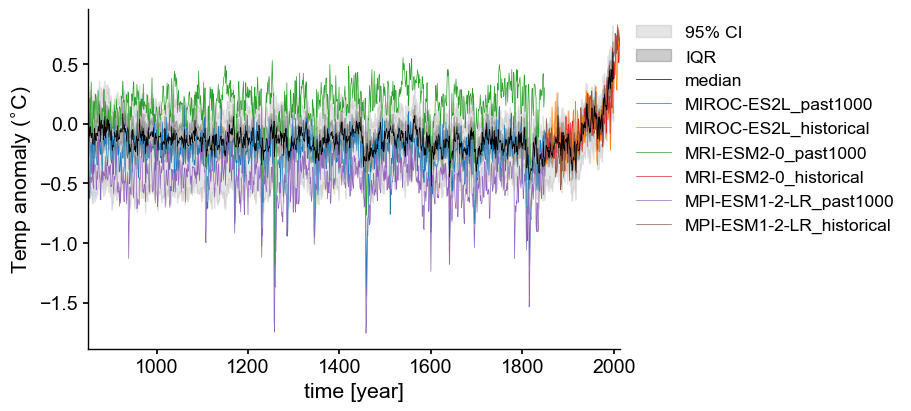

In [98]:
fig = plt.figure(figsize=(9, 4), layout="constrained")
spec = fig.add_gridspec(4, 1, hspace=.20)

ax2 = fig.add_subplot(spec[:4, :])

# Same EnsembleSeries envelope from above, this time with lines that correspond to volcanic events
lmr_ens.plot_envelope( shade_alpha = .1,  ylabel='GMST [$^{\circ}$C]', 
                                                   curve_lw=.5, shade_clr='k', curve_clr='k', ax=ax2)
for key in annualized_anomaly_gwm.keys():
    for exp in annualized_anomaly_gwm[key].keys():
        annualized_anomaly_gwm[key][exp]['ps'].plot(ax=ax2, linewidth=.5)
    
ax2.xaxis.set_ticks_position('bottom')
ax2.grid(False)
ax2.legend(bbox_to_anchor = (1,1))

xlims = [850, 2014]
ax2.set_xlim(xlims)

<font color=blue> Better? </font>

Great! Now we can see how the physics-based GCM simulations compare to the envelope of LMR reconstructions. All three models closely follow the increase captured by the reconstructions over the "historical" period (1850-2014) and show an approximately flat trend over the "past1000k" interval. Different GCMs use different approaches to describe the physics behind earth system processes. Therefore, it is not surprising to see slight offsets among them or differences in the interannual variability superimposed on the trends.

Punctuating the "past1000k" interval are a series of abrupt decreases, coincident across all models, that correspond to volcanic eruptions. The recovery period length varies by model, but broadly, the temperature response follows the reconstructed trajectory. Based on these observations, we can conclude that the model physics are true to pre-industrial climate dynamics. Furthermore, the amplitude of the post-1850 increase is too large to be attributed to pre-1850 interannual variability alone, suggesting that anthropogenic forcing must have played a significant role.




## Spatial Visualization
<font color=blue> I wrote it long, and then wondered if that was too much language </font>

The global mean can indeed be a valuable summary statistic for examining overarching or long-term trends in climate variables, as it provides a single value that represents the average across all locations on the planet. It can help identify general patterns and trends in climate change that may not be apparent when examining spatially heterogeneous data.

However, it's important to acknowledge that local nuance and spatial heterogeneity can play a significant role in understanding climate dynamics and system responses to perturbations. Patterns of local nuance that may be insignificant when considered in the context of the global mean can still offer valuable insights into more local processes or regional dynamics attached to feedback mechanisms that can influence the response of a system to climate change.

Furthermore, examining local nuance can provide important information about model sensitivity and accuracy. Climate models are based on complex mathematical equations and assumptions, and their outputs may not always accurately capture local-scale variability. By examining spatial distribution of climate variables, we can identify areas where models may deviate from observed data, leading to improvements in model development and validation.

<font color=blue> so I rewrote it </font>

The global mean collapses spatial heterogeneity into a single summary statistic that is valuable for looking at over-arching or long-term trends where local nuance would distract. However, sometimes patterns of local nuance that cancel each other out or are quantitatively insignificant in the context of the global mean are indicators of important dynamics, response to system perturbations, or offer useful information about model sensitivity. 

<font color=blue> But I'm not sure which is the right call (or neither) </font>


<font color=green> Scientifically, why do people want to look at things over space? Let's start with that instead of diving head-first into technicalities. You're not even explaining that you are picking the year 1816 or why... That's kind of relevant, wouldn't you think? </font> 


**Zooming in on the Tambora Eruption**

Let's take a look at one of those abrupt decreases mentioned earlier. In 1816, Tambora erupted, releasing a huge plume of sulfate aerosols into the atmosphere, causing global cooling. That was visible in the global mean anomaly timeseries, but now let's also look into the spatial distribution for the three models and the LMR reconstruction at that time, and also the time evolution of the temperature anomaly in a specific place (in contrast to the global mean we looked at earlier). The final figure will contain:

- Four snapshot maps (one for each model + LMR) that show the spatial distribution of temperature anomaly at a particular point in time
- One plot of the time evolution of temperature anomaly at a specific location for each model + LMR 

In [115]:
lat = -30
lon = 200

# Tambora
tam_lat = -8.2479
tam_lon = 117.9911
time_pt = 1816

In [100]:
cmip6_snapshot_ps = {}

### LMR
Previously, we loaded 1000 LMR member traces of global mean temperature anomaly. As a matter of computational practicality, only 20 members are available in spatial resolution. Here, we will load those data from Pangeo-Forge and average over the 20 members so that we have a single spatial distribution at each time step.  

<font color=green> Explain the difference with the netCDF file loaded in the previous section</font>

In [101]:
# Load data using Pangeo-Forge
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1200/LMRv2p1_MCruns_ensemble_gridded.zarr"
lmr_ds_gridded = xr.open_dataset(store, engine='zarr', chunks={})


In [102]:
# temperature anomaly
lmr_ds_gridded_temp = lmr_ds_gridded['air_mean']

# spatial distribution of temperature amomaly (average of members)
lmr_ds_gridded_temp_mean = lmr_ds_gridded_temp.mean(dim='MCrun')

In [103]:
%%time
# this takes about 1.5 minutes
timeseries = lmr_ds_gridded_temp.sel({'lon': lon, 'lat': lat}, method="nearest")
timeseries = timeseries.chunk({'time':1}).compute()

MCrun_grps = [grp for grp in timeseries.groupby('MCrun')]
tmp_pss = []
for MCrun_grp in MCrun_grps:
    MCrun = MCrun_grp[1]
    tmp_pss.append(pyleo.Series(MCrun.time.dt.year, MCrun.data, time_unit='year', clean_ts=False, value_name='MCrun {}'.format(MCrun_grp[0])))


CPU times: user 22.4 s, sys: 9.02 s, total: 31.4 s
Wall time: 1min 43s


In [104]:
surftemp_mean = timeseries.mean(dim='MCrun').compute()
snapshot_data = lmr_ds_gridded_temp_mean.sel(time=(lmr_ds_gridded_temp_mean.time.dt.year == time_pt))

cmip6_snapshot_ps['LMR2.1'] = {'snapshot':snapshot_data, 
                               'ps_atloc': {'full':pyleo.Series(surftemp_mean.time.dt.year, surftemp_mean.data, label='LMR2.1', time_unit='year', clean_ts=False)}}

### CMIP6
Now we'll return to the annualized anomaly calculation we did earlier to pull the spatial snapshot at `time_pt` and the time series at `lat`,`lon`  for each of our CMIP6 models. Pulling all of these pieces together will make the plotting easier.  
<font color=green> What's happening here?</font>

In [112]:
annualized_anomaly_spatial[institution].keys()

dict_keys(['past1000', 'historical'])

In [111]:
annualized_anomaly_spatial['MIROC'][exp].year

<xarray.DataArray 'year' (year: 165)>
array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861,
       1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873,
       1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
       1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897,
       1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014

In [114]:
%%time
# this may take ~5 minutes
for institution in annualized_anomaly_spatial.keys():
    exp_d = {}
    for exp in annualized_anomaly_spatial[institution].keys():
        # select spatial distribution at time_pt
        if time_pt in annualized_anomaly_spatial[institution][exp].year:
            snapshot_anom = annualized_anomaly_spatial[institution][exp].sel({'year':time_pt}).squeeze()
        
        # select time series at lat,lon location
        ts_atloc = annualized_anomaly_spatial[institution][exp].sel({'lon': lon, 'lat': lat}, method="nearest").chunk(
            {'year':len(annualized_anomaly_spatial[institution][exp].year)}).squeeze().compute()
        exp_d[exp] = pyleo.Series(ts_atloc.year, ts_atloc.data, time_unit='year', clean_ts=False, label= '_'.join([institution, exp]))
    
    cmip6_snapshot_ps[institution]= {'snapshot':snapshot_anom, 'ps_atloc':exp_d}


MIROC
past1000
check
historical
MRI
past1000
check
historical
MPI
past1000
check
historical
CPU times: user 2min 34s, sys: 49 s, total: 3min 23s
Wall time: 7min 5s


### Combined figure
Finally, we'll build the figure. For more details about building filled contour maps and wrangling color bars, check out [this lifehack notebook](../lifehacks/spatial_snapshots_xarray_bonuses.ipynb) and for more on dashboards, check out [this science bit](./VICS_dashboard.ipynb).

In [106]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if n is None:
        ax_cmap = plt.get_cmap(cmap)
    else:    
        ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

In [116]:
lims = [np.abs(cmip6_snapshot_ps[key]['snapshot'].max().compute()) for key in cmip6_snapshot_ps.keys()]
lims += [np.abs(cmip6_snapshot_ps[key]['snapshot'].min().compute()) for key in cmip6_snapshot_ps.keys()]

# establish scale
ax2_Li_1 = max(lims)
ax2_levels = np.around(np.linspace(-ax2_Li_1, ax2_Li_1, 15), decimals=1)
# make scalar mappable
ax2_sm = make_scalar_mappable([ax2_Li_1, -ax2_Li_1], 'RdBu_r', 15)
cf2_kwargs = {'cmap':ax2_sm.cmap, 'norm' : ax2_sm.norm}


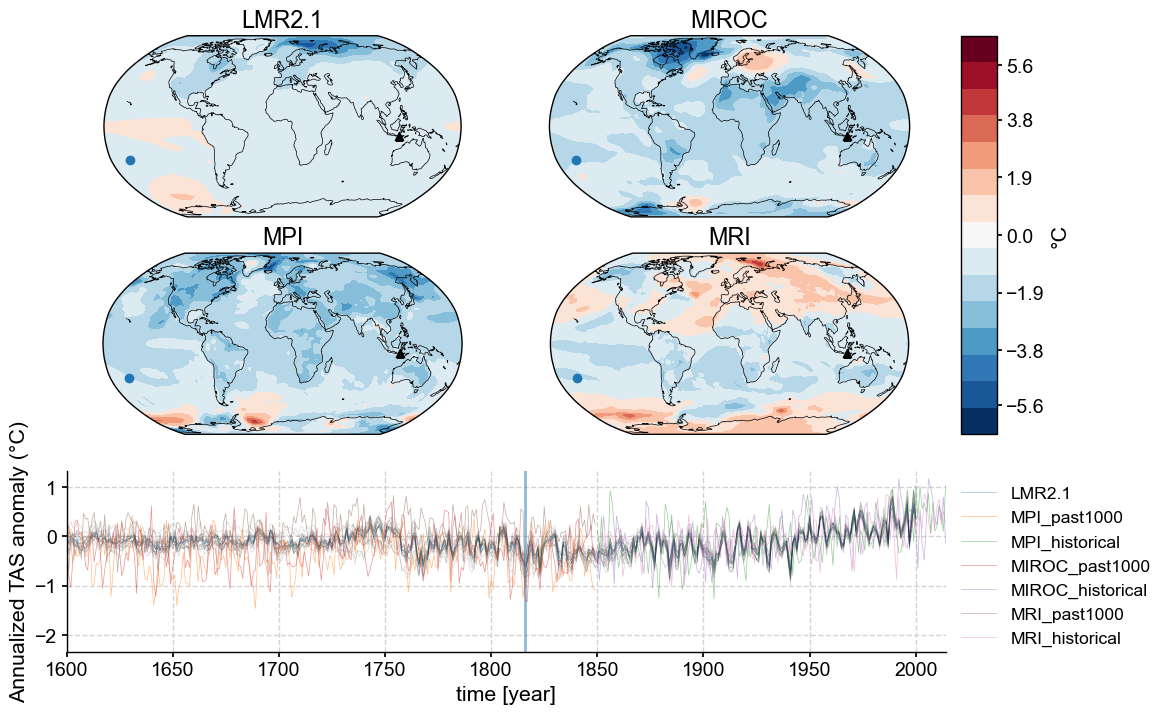

In [119]:
nc = 21
fig = plt.figure(figsize=(12, 8))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(3, 3, wspace=0.05, hspace=.2,width_ratios=[3,3,.25], height_ratios=[3,3,3])

# add subplot with specified map projection and coastlines (GeoAxes)
gs_squares = [gs[0, 0], gs[0, 1], gs[1, 0], gs[1, 1]]
axs = [fig.add_subplot(sqr, projection=ccrs.Robinson(central_longitude=0)) for sqr in gs_squares]

for ik, key in enumerate(['LMR2.1', 'MIROC', 'MPI', 'MRI']):#cmip6_snapshot_ps.keys()):
    axs[ik].add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)
    # place data on coordinate system with continuous x axis (longitude axis)
    tas_c, lonc = cutil.add_cyclic_point(cmip6_snapshot_ps[key]['snapshot'], cmip6_snapshot_ps[key]['snapshot']['lon'])
    # plot contourf on ax2 (geosubplot)
    cf2 = axs[ik].contourf(lonc,cmip6_snapshot_ps[key]['snapshot']['lat'],tas_c.squeeze(),nc, levels=ax2_levels, 
                       transform=ccrs.PlateCarree(), **cf2_kwargs)
    axs[ik].scatter(lon, lat, transform=ccrs.PlateCarree())
    axs[ik].set_title(key)
    axs[ik].scatter(tam_lon, tam_lat, marker='^', color='k', transform=ccrs.PlateCarree())


# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[:2, 2])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label="\xb0C", 
                   ticks=[loc for ik, loc in enumerate(ax2_levels) if ik%2>0])
cb2.minorticks_off()                     

# time series
ax_ts = fig.add_subplot(gs[2, :2])
ax_ts.axvline(x=time_pt, alpha=.5)
for MCrun_ps in tmp_pss:
    MCrun_ps.plot(ax=ax_ts, color='k', alpha=.15, linewidth=.5)

# CMIP6 trajectories
for key in cmip6_snapshot_ps.keys():
    for exp in cmip6_snapshot_ps[key]['ps_atloc'].keys():
        cmip6_snapshot_ps[key]['ps_atloc'][exp].plot(ax=ax_ts, linewidth=.5, alpha=.5)
        
ax_ts.legend(bbox_to_anchor=(1,1))
ax_ts.set_xlim([1600, 2014])
ax_ts.set_ylabel('Annualized TAS anomaly (\xb0C)');

---

## Summary
Comparing model output to data is a critical step in assessing how well a physics-based model describes the Earth system. Here we demonstrated how to look at time series data next to spatial snapshots to tease out the details behind the larger patterns. There are many more potential things we could do with this. In future notebooks, we will:
- map the multivariate response to volcanic eruptions (see [VICS dashboards](./VICS_dashboard.ipynb)) 
- analyze the main modes of climate variability in reconstructions and simulations.


## Resources and references

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Hakim, G. J., Emile-Geay, J., Steig, E. J., Noone, D., Anderson, D. M., Tardif, R., Steiger, N., and Perkins, W. A. (2016), The last millennium climate reanalysis project: Framework and first results, J. Geophys. Res. Atmos., 121, 6745– 6764, doi:10.1002/2016JD024751.|
| Tardif, R., Hakim, G. J., Perkins, W. A., Horlick, K. A., Erb, M. P., Emile-Geay, J., Anderson, D. M., Steig, E. J., and Noone, D.: Last Millennium Reanalysis with an expanded proxy database and seasonal proxy modeling, Clim. Past, 15, 1251–1273,  https://doi.org/10.5194/cp-15-1251-2019 , 2019. |
|  Neukom, R., L. A. Barboza, M. P. Erb, F. Shi, J. Emile-Geay, M. N. Evans, J. Franke, D. S. Kaufman, L. Lücke, K. Rehfeld, A. Schurer, F. Zhu, S. Br ̈onnimann, G. J. Hakim, B. J. Henley, F. C. Ljungqvist, N. McKay, V. Valler, and L. von Gunten (2019), Consistent multidecadal variability in global temperature reconstructions and simulations over the common era, Nature Geoscience, 12(8), 643–649, doi:10.1038/s41561-019-0400-0. |
| Kageyama, M., Braconnot, P., Harrison, S. P., Haywood, A. M., Jungclaus, J. H., Otto-Bliesner, B. L., Peterschmitt, J.-Y., Abe-Ouchi, A., Albani, S., Bartlein, P. J., Brierley, C., Crucifix, M., Dolan, A., Fernandez-Donado, L., Fischer, H., Hopcroft, P. O., Ivanovic, R. F., Lambert, F., Lunt, D. J., Mahowald, N. M., Peltier, W. R., Phipps, S. J., Roche, D. M., Schmidt, G. A., Tarasov, L., Valdes, P. J., Zhang, Q., and Zhou, T.: The PMIP4 contribution to CMIP6 – Part 1: Overview and over-arching analysis plan, Geosci. Model Dev., 11, 1033–1057, https://doi.org/10.5194/gmd-11-1033-2018, 2018.|
